# Jenius forecasting - Funded customers <a class="tocSkip">
*Beatriz Bueno Larraz*

Funded customers are the ones having balance larger than Rp10.000. We want to forecast the daily number of funded customers.

Summary of the prediction model:
- We use a moving median with a window of 29 days, and then adjust a straight line to these values to predict the trend of the series
- We use seasonal indices for week day, holidays, pay day, 28th day of each month and previous working day to the 28th 
- Those indices are computed using the median of the trend ratios for each group instead of the mean 
- In order to forecast a day we use just the extreme values of the indeces (min. value of indices less than 1 and max. value of indices greater than 1)
- For the peaks days (28th) we set all indices to 1 except the index_28th

In [125]:
import gc
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

In [127]:
df = pd.read_csv("input/Funded_customers.csv", parse_dates=['Date'], thousands=',')
df.columns= ['date', 'n_funded_cust', 'daily_change']
df.loc[df['daily_change']<200, 'daily_change'] = df['daily_change'].median() #Impute too small values as the median
print("{:,} daily measures from {} to {}.".format(df.shape[0], df['date'].min().strftime("%B %dst %Y"), df['date'].max().strftime("%B %dth %Y")))

241 daily measures from June 01st 2018 to January 31th 2019.


In [128]:
#Empty rows for the test set
end_day = dt.datetime.strptime('2020-01-31', '%Y-%m-%d')

df_test = pd.DataFrame(columns=df.columns)
n_new_days = (end_day - df.iloc[df.shape[0]-1]['date']).days
df_test['date'] = [end_day - datetime.timedelta(days=x) for x in range(n_new_days-1,-1,-1)]
df_test['n_funded_cust'] = [np.nan]*df_test.shape[0]
df_test['daily_change'] = [np.nan]*df_test.shape[0]

In [129]:
df = df.append(df_test, ignore_index=True)

# Detect special days.

In [130]:
#Day of the week
df['week'] = df['date'].dt.dayofweek

#Payment days
pay_days = ['6/25/2018', '7/25/2018', '8/24/2018', '9/25/2018', '10/25/2018', '11/23/2018', '12/21/2018', '12/31/2018', '1/25/2019', '2/25/2019', '3/25/2019', '4/25/2019', '5/24/2019', '6/25/2019', '7/25/2019', '8/23/2019', '9/25/2019', '10/25/2019', '11/25/2019', '12/23/2019', '12/31/2019', '1/24/2020']
df['pay_day'] = 1*(df['date'].isin([dt.datetime.strptime(d, '%m/%d/%Y') for d in pay_days]))

#Public holidays
df_ph = pd.read_csv('input/indonesian_public_holidays_2018-19.csv', sep=';', parse_dates=['date'])
df_ph.drop('english_name', axis=1, inplace=True)
df['is_holiday'] = 1*(df['date'].isin(pd.to_datetime(df_ph['date'])))

#Day 28th of each month
df['28th'] = 1*(df['date'].dt.day==28)

The previous working day to the 28th also has greater values.

In [131]:
df['work_prev_28th'] = [0]*df.shape[0]
df.loc[(df['date'].dt.day==27) & (df['week']!=6) & (df['week']!=5), 'work_prev_28th'] = 1

df.loc[(df['date'].dt.day==27) & ((df['week']==6) | (df['week']==5))]

,date,n_funded_cust,daily_change,week,pay_day,is_holiday,28th,work_prev_28th
148,2018-10-27,362645.0,797.0,5,0,0,0,0
237,2019-01-27,446985.0,721.0,6,0,0,0,0
326,2019-04-27,NaN,NaN,5,0,0,0,0
417,2019-07-27,NaN,NaN,5,0,0,0,0
509,2019-10-27,NaN,NaN,6,0,0,0,0


In [132]:
#For this small data set is easier to mark those days by hand
d1 = dt.datetime.strptime('2018-10-26', '%Y-%m-%d')
d2 = dt.datetime.strptime('2019-01-25', '%Y-%m-%d')
d3 = dt.datetime.strptime('2019-04-26', '%Y-%m-%d')
d4 = dt.datetime.strptime('2019-07-26', '%Y-%m-%d')
d5 = dt.datetime.strptime('2019-10-25', '%Y-%m-%d')
df.loc[df['date'].isin([d1, d2, d3, d4, d5]), 'work_prev_28th'] = 1

# Trend
For each point we compute the median of the 14 previous days and the 14 following days (rolling median), and the trend is computed by adjusting a line to these values.

In [133]:
#Rolling median
df['MMedian29'] = df['daily_change'].rolling(window=29, center=True, min_periods=26).median()

#Linear regression
x_trend = df[df['MMedian29'].notnull()]['date'].map(datetime.datetime.toordinal).values
x_mean = x_trend.mean()
x_trend = x_trend - x_mean #If not the estimation of b0 is really poor
y_trend = df[df['MMedian29'].notnull()]['MMedian29'].values

#Regression coefficients
b1 = np.cov(x_trend,y_trend)[0,1]/np.cov(x_trend,y_trend)[0,0]
b0 = y_trend.mean() - b1*x_trend.mean()

#Trend
x_trend = df['date'].map(datetime.datetime.toordinal).values - x_mean
df['trend'] = b0+b1*x_trend

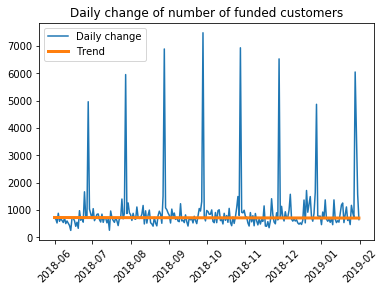

In [134]:
df_data = df[df['date']<dt.datetime.strptime('2019-2-1', '%Y-%m-%d')]
plt.plot(df_data['date'], df_data['daily_change'], label='Daily change')
plt.xticks(rotation = 45)
plt.plot(df_data['date'], df_data['trend'], label='Trend', linewidth=3)
plt.title('Daily change of number of funded customers')
plt.legend()
plt.show()

# Seasonal indices
We remove the 28th days for the computation of the indices.

In [135]:
df['ratio'] = df['daily_change']/df['trend']
df_temp = df[df['28th']!=1] #Remove 28th

#Indices for week days: 
df_temp_group = df_temp.groupby('week')['ratio'].median().reset_index()
df_temp_group.rename(columns={'ratio': 'index_week'}, inplace=True)
df = df.merge(df_temp_group, on='week', how='left')

#Indices for the pay days:
df_temp_group = df_temp.groupby('pay_day')['ratio'].median().reset_index()
df_temp_group.rename(columns={'ratio': 'index_payday'}, inplace=True)
df_temp_group.loc[0,'index_payday'] = 1 #We want only the index for pay days
df = df.merge(df_temp_group, on='pay_day', how='left')

#Indices for holidays:
df_temp_group = df_temp.groupby('is_holiday')['ratio'].median().reset_index()
df_temp_group.rename(columns={'ratio': 'index_holiday'}, inplace=True)
df_temp_group.loc[0,'index_holiday'] = 1 #We want only the index for holidays
df = df.merge(df_temp_group, on='is_holiday', how='left')

#Indices for 28th days:
df_temp_group = df.groupby('28th')['ratio'].median().reset_index()
df_temp_group.rename(columns={'ratio': 'index_28th'}, inplace=True)
df_temp_group.loc[0,'index_28th'] = 1 #We want only the index for 28th
df = df.merge(df_temp_group, on='28th', how='left')

#Indices for the day previous to 28th:
df_temp_group = df_temp.groupby('work_prev_28th')['ratio'].median().reset_index()
df_temp_group.rename(columns={'ratio': 'index_prev28th'}, inplace=True)
df_temp_group.loc[0,'index_prev28th'] = 1 #We want only the index for the days before 28th
df = df.merge(df_temp_group, on='work_prev_28th', how='left')

In [136]:
#For peaks set all indices to 1
df.loc[df['28th']==1, 'index_week'] = 1 
df.loc[df['28th']==1, 'index_payday'] = 1 
df.loc[df['28th']==1, 'index_holiday'] = 1

# Forecasting

In [194]:
#Estimation
df_indices = df[['index_week', 'index_holiday', 'index_payday', 'index_28th', 'index_prev28th']]
df['estim'] = df['trend']*df_indices[df_indices<=1].min(axis=1)*df_indices[df_indices>=1].max(axis=1)

## Daily change

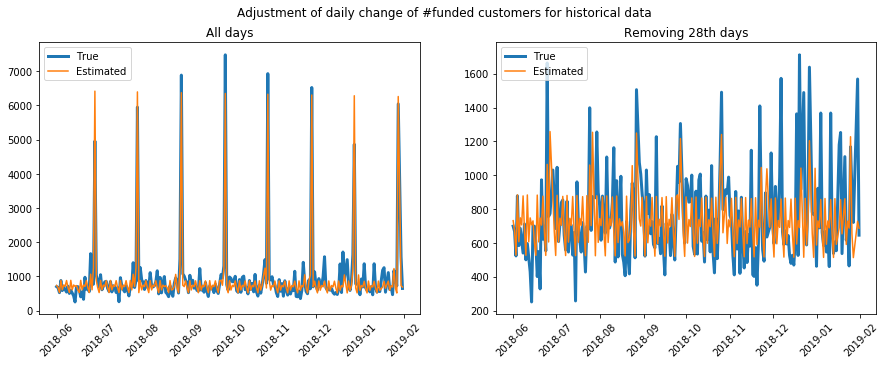

In [195]:
df_data = df[df['date']<dt.datetime.strptime('2019-2-1', '%Y-%m-%d')]
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(df_data['date'], df_data['daily_change'], label='True', linewidth=3)
plt.xticks(rotation = 45)
plt.plot(df_data['date'], df[df['date'].isin(df_data['date'])]['estim'], label='Estimated')
plt.title('All days')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(df[df['daily_change']<4000]['date'], df[df['daily_change']<4000]['daily_change'], label='True', linewidth=3)
plt.xticks(rotation = 45)
plt.plot(df[df['daily_change']<4000]['date'], df[df['daily_change']<4000]['estim'], label='Estimated')
plt.title('Removing 28th days')
plt.legend(loc='upper left')
plt.suptitle('Adjustment of daily change of #funded customers for historical data')
plt.show()

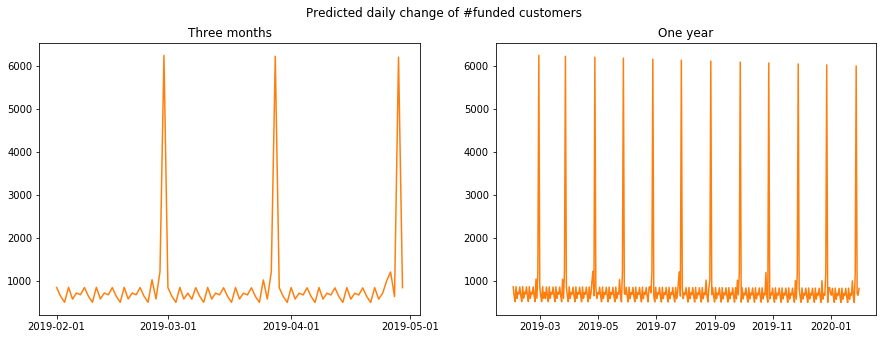

In [186]:
plt.figure(figsize=(15, 5))
df_future = df[df['date']>dt.datetime.strptime('2019-1-31', '%Y-%m-%d')]

plt.subplot(1,2,1)
plt.plot(df_future[df_future['date']<dt.datetime.strptime('2019-4-30', '%Y-%m-%d')]['date'], df_future[df_future['date']<dt.datetime.strptime('2019-4-30', '%Y-%m-%d')]['estim'], 'C1')
locs, labels = plt.xticks()
plt.xticks(locs[[1,3,6,9]])
plt.title('Three months')

plt.subplot(1,2,2)
plt.plot(df_future['date'], df_future['estim'], 'C1', label='Estimated')
plt.title('One year')

plt.suptitle('Predicted daily change of #funded customers')
plt.show()

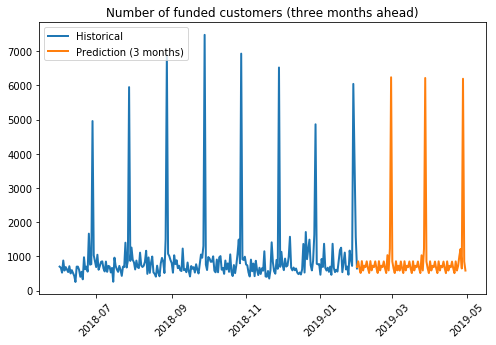

In [191]:
plt.figure(figsize=(8, 5))
plt.plot(df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['date'], df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['daily_change'], label='Historical', linewidth=2)
plt.xticks(rotation = 45)
three_months = df[(df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')) & (df['date']>=dt.datetime.strptime('2019-1-31', '%Y-%m-%d'))]['date'].values
plt.plot(df[df['date'].isin(three_months)]['date'], df[df['date'].isin(three_months)]['estim'], label='Prediction (3 months)', linewidth=2)
plt.title('Number of funded customers (three months ahead)')
plt.legend(loc='upper left')
plt.show()

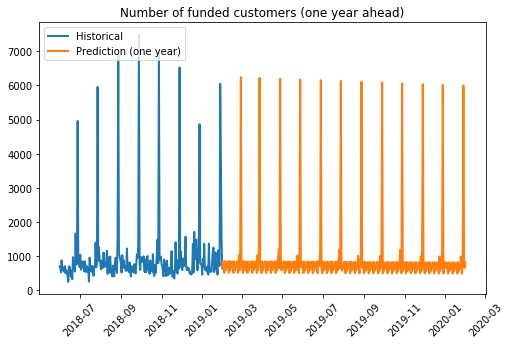

In [196]:
plt.figure(figsize=(8, 5))
plt.plot(df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['date'], df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['daily_change'], label='Historical', linewidth=2)
plt.xticks(rotation = 45)
one_year = df[(df['date']<dt.datetime.strptime('2020-2-1', '%Y-%m-%d')) & (df['date']>=dt.datetime.strptime('2019-1-31', '%Y-%m-%d'))]['date'].values
plt.plot(df[df['date'].isin(one_year)]['date'], df[df['date'].isin(one_year)]['estim'], label='Prediction (one year)', linewidth=2)
plt.title('Number of funded customers (one year ahead)')
plt.legend(loc='upper left')
plt.show()

## Total number of funded customers

Total number of funded customers predicted for the next three months.

In [171]:
df_data = df[(df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')) & (df['date']>=dt.datetime.strptime('2019-1-31', '%Y-%m-%d'))]
predictions = df_data['estim'].values
predictions[0] = df_data.iloc[0]['n_funded_cust']
df['pred_cum'] = [0]*df.shape[0]
df.loc[df['date'].isin(df_data['date']), 'pred_cum'] = np.cumsum(predictions).round()

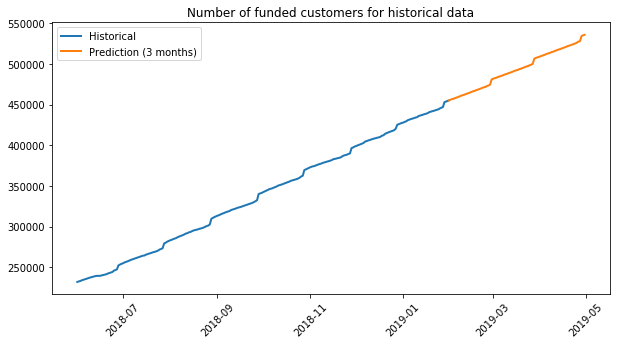

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['date'], df[df['date']<dt.datetime.strptime('2019-5-1', '%Y-%m-%d')]['n_funded_cust'], label='Historical', linewidth=2)
plt.xticks(rotation = 45)
plt.plot(df_data['date'], df[df['date'].isin(df_data['date'])]['pred_cum'], label='Prediction (3 months)', linewidth=2)
plt.title('Number of funded customers for historical data')
plt.legend(loc='upper left')
plt.show()